In [2]:
from bs4 import BeautifulSoup
import requests
import time, os

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

import pandas as pd
import numpy as np
import re

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

In [3]:
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)
driver.get('http://www.ravelry.com/patterns')
time.sleep(1)  #pause to be sure page has loaded

username = 'XXXXXXXX' #USER NAME REMOVED
password = 'XXXXXXXX' #PASSWORD REMOVED

#from https://www.thepythoncode.com/article/automate-login-to-websites-using-selenium-in-python
driver.find_element_by_id("user_login").send_keys(username)
driver.find_element_by_id("user_password").send_keys(password)
driver.find_element_by_id("remember_me").click()
driver.find_element_by_class_name("splash_page__submit__login").click()
driver.find_element_by_id("query").send_keys(Keys.RETURN)
time.sleep(3)
driver.find_element_by_id('query').send_keys('sweater')
driver.find_element_by_id('query').send_keys(Keys.RETURN)
time.sleep(3)


list_of_sweaters = []
def read_page_for_html(m):
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    q = soup.find_all('a',class_='pattern_name')

    for i in range(len(q)):
        m.append(q[i]['href'])
    return m

def read_multiple_pages(num_of_pages):
    for i in range(num_of_pages):
        driver.find_element_by_class_name("next_page").click()
        time.sleep(3)

        read_page_for_html(list_of_sweaters)
    list_of_sweaters

read_page_for_html(list_of_sweaters)

read_multiple_pages(50)

los = pd.DataFrame(list_of_sweaters)
los.to_csv('list_of_sweater_sites.csv')

In [4]:
len(list_of_sweaters)

2448

In [5]:

cols = ['price','currency','lang','num_proj','num_tags','craft','yarn_weight','gauge','yardage','size_avail','chart','crewneck','one-piece','seamless','top-down','unisex','written-pattern']
df = pd.DataFrame(columns = cols)

#print(df)

for i in range(len(list_of_sweaters)):
#for i in range(500):
    url = list_of_sweaters[i]
    #print(url)
    response = requests.get(url)
    if response.status_code <300:
        #print(response.status_code)
        page = response.text
        soup = BeautifulSoup(page, "lxml")        

        #price
        temp = soup.find(class_ = 'price_retail')
        if temp != None:
            temp2 = temp.text.split()
        else:
            temp2 = ['free','free']
        if temp2[0] == 'free!':
            temp2 = ['free','free']
        elif temp2[0] == 'free':
            temp2 = ['free','free']
        #if temp2[1] != 'USD':
         #   temp2 = ['free','free']
        #print(temp2)
        price=temp2[0]
        currency = temp2[1]
        
        #langauge
        temp = soup.find(class_="core_item_content__field__language")
        temp = soup.find(class_="core_item_content__field__language")
        if temp != None:
            language = temp.text.strip()
        else:
            language = 'English'
        
        #number of projects
        temp3 = soup.find_all(class_='o-icon--projects')
        mm=temp3[0].next_element.next_element.next_element.split()
        if mm[0] == 'no':
            num_proj=(0)
        else:
            num_proj=(int(mm[0]))
            
        #tags
        tag_all = []
        tags=[]
        temp4 = soup.find(class_='core_item__tags')
        temp5 = temp4.find_all('li')
        chart = ''
        crewneck = ''
        one_piece = ''
        seamless = ''
        top_down = ''
        unisex = ''
        written_pattern = ''
        for i_tag in range(len(temp5)):
            if temp5[i_tag].text.strip() == 'chart':
                chart = 1
            if temp5[i_tag].text.strip() == 'crewneck':
                crewneck = 1
            if temp5[i_tag].text.strip() == 'one-piece':
                one_piece = 1
            if temp5[i_tag].text.strip() == 'seamless':
                seamless = 1
            if temp5[i_tag].text.strip() == 'top-down':
                top_down = 1
            if temp5[i_tag].text.strip() == 'unisex':
                unisex = 1
            if temp5[i_tag].text.strip() == 'written-pattern':
                written_pattern = 1
            tags.append(temp5[i_tag].text.strip())
        tag_all =tags
        num_tags = len(tag_all)

    
        # get craft, yarn weight, gauge, yardage,sizes
        x = soup.find('fieldset').find_all('label',class_ = 'core_item_content__label')
        for j in range(len(x)):
            if x[j].text.strip() == 'Craft':
                craft =x[j].next_element.next_element.next_element.text.strip()
            if x[j].text.strip() == 'Yarn weight':
                yarn_weighta = (x[j].next_element.next_element.next_element.text.strip())
                yarn_weightb = yarn_weighta.split('(')
                yarn_weight = yarn_weightb[0].strip()
            if x[j].text.strip() == 'Gauge':
                gaugea = (x[j].next_element.next_element.next_element.text.strip())
                gaugeb = gaugea.split(' stitches')
                gauge = gaugeb[0]
            if x[j].text.strip() == 'Yardage':
                yardagea=(x[j].next_element.next_element.next_element.text.strip())
                yardageb = re.split(' - | yards', yardagea)
                #re.split('; |, ',str)
                yardage = yardageb[1]
            if x[j].text.strip() == 'Sizes available':
                size_availa=x[j].next_element.next_element.next_element.text.strip()
                szavb = size_availa.split()
                size_avail = len(szavb)

        

        
        temp_array = []
        temp_array.append(price)
        temp_array.append(currency)
        temp_array.append(language)
        temp_array.append(num_proj)
        #print(len(tag_all))
        #for i in range(len(tag_all)):
        #temp_array.append(tag_all)
        temp_array.append(num_tags)
        temp_array.append(craft)
        if yarn_weight:
            temp_array.append(yarn_weight)
        else:
            temp_array.append('free')
        if gauge:
            temp_array.append(gauge)
        else:
            temp_array.append('free')
        if yardage:
            temp_array.append(yardage)
        else:
            temp_array.append('free')
        if size_avail:
            temp_array.append(size_avail)
        else:
            temp_array.append('free')
        if chart:
            temp_array.append(chart)
        else:
            temp_array.append(0)
        if crewneck:
            temp_array.append(1)
        else:
            temp_array.append(0)        
        if one_piece:
            temp_array.append(1)
        else:
            temp_array.append(0)
        if seamless:
            temp_array.append(1)
        else:
            temp_array.append(0) 
        if top_down:
            temp_array.append(1)
        else:
            temp_array.append(0) 
        if unisex:
            temp_array.append(1)
        else:
            temp_array.append(0) 
        if written_pattern:
            temp_array.append(1)
        else:
            temp_array.append(0) 

        df = df.append(dict(zip(df.columns, temp_array)), ignore_index=True)



In [6]:
#print(df)
df.shape

(2448, 17)

In [16]:
df.to_csv(r'webscraping.csv')

In [8]:
#df.info()

In [3]:
df2 = pd.read_csv('webscraping.csv')

In [4]:
df2 = df2.replace(['free'],np.NaN)
df3 = df2.copy()


df3 = df3.dropna(axis = 0)
df3.reset_index(drop = True,inplace= True)
df3['price'] = df3['price'].replace({'[^0-9]':''},regex = True)
df3['yardage'] = df3['yardage'].replace({'[^0-9]':''},regex = True)
df3 =df3[df3['currency']=='USD']
df3['gauge'] = df3['gauge'].replace({'[^0-9]':0},regex = True)

df4 = df3.astype({'price':int})

df4 = df4.astype({'gauge': float})
df4 = df4.astype({'yardage':int})

df4['price'] = df4['price']/100

#df4.info()

#df2.describe()
#df4.head()
#df4['price']
#xx

In [5]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 1731
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       837 non-null    int64  
 1   price            837 non-null    float64
 2   currency         837 non-null    object 
 3   lang             837 non-null    object 
 4   num_proj         837 non-null    int64  
 5   num_tags         837 non-null    int64  
 6   craft            837 non-null    object 
 7   yarn_weight      837 non-null    object 
 8   gauge            837 non-null    float64
 9   yardage          837 non-null    int64  
 10  size_avail       837 non-null    int64  
 11  chart            837 non-null    int64  
 12  crewneck         837 non-null    int64  
 13  one-piece        837 non-null    int64  
 14  seamless         837 non-null    int64  
 15  top-down         837 non-null    int64  
 16  unisex           837 non-null    int64  
 17  written-pattern

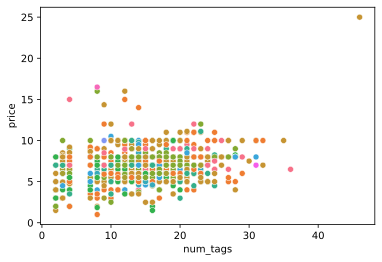

In [9]:
fig = sns.scatterplot(x=df4['num_tags'], y=df4['price'], hue=df4['yarn_weight'],legend = False)
#fig.savefig('numtagsByColor.png', bbox_inches='tight')
plt.savefig('numtagsByColor.png')

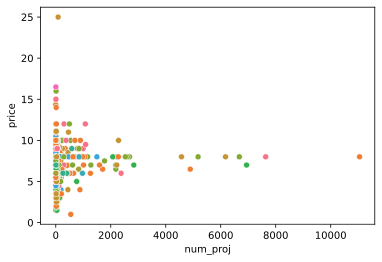

In [10]:
sns.scatterplot(x=df4['num_proj'], y=df4['price'], hue=df4['yarn_weight'],legend = False)
plt.savefig('numProjByColor.png')

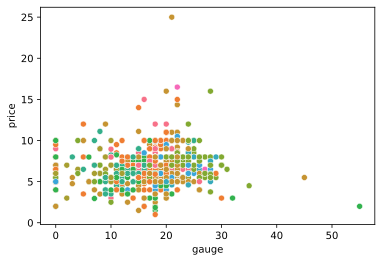

In [11]:
sns.scatterplot(x=df4['gauge'], y=df4['price'], hue=df4['yarn_weight'],legend = False)
plt.savefig('gaugeByColor.png')

In [12]:
just_dummies = pd.get_dummies(df4['yarn_weight'])
df5 = pd.concat([df4,just_dummies],axis = 1)
df5.drop(['Unnamed: 0','yarn_weight','Super Bulky'],inplace = True, axis = 1)

df5.drop(['currency'],inplace = True, axis = 1)
df6=df5[(df5['yardage'] < 10000)]
df6 = df6[(df6['price']<20)]
print(df6['yardage'].max())

df6.info()


9240
<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 0 to 1731
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   price                                  833 non-null    float64
 1   lang                                   833 non-null    object 
 2   num_proj                               833 non-null    int64  
 3   num_tags                               833 non-null    int64  
 4   craft                                  833 non-null    object 
 5   gauge                                  833 non-null    float64
 6   yardage                                833 non-null    int64  
 7   size_avail                             833 non-null    int64  
 8   chart                                  833 non-null    int64  
 9   crewneck                               833 non-null    int64  
 10  one-piece                              833 non-null    int64  
 11  

In [9]:
#df5.info()

In [10]:
#### NOT RUN BECAUSE CRASHES LAPTOP ####
sns.set(context='notebook', style='whitegrid', font_scale=1.2)
#fig = sns.pairplot(df5, height=1.2, plot_kws=dict(alpha=.1, edgecolor='none'));
# #Plot all of the variable-to-variable relations as scatterplots
##fig = sns.pairplot(df5, height=1.2, plot_kws={'s': 6});
#fig.savefig('my_lineplot.png', bbox_inches='tight') 

In [13]:
y = df6['price']
X = df6.drop('price',axis = 1)

In [80]:
#X.info()

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
just_dummies = pd.get_dummies(X_train['craft'])
X_train = pd.concat([X_train,just_dummies],axis = 1)
X_train.drop(['craft','lang','Machine Knitting'],inplace = True, axis = 1)


In [16]:
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42)

In [17]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)
lr.score(X_tr,y_tr)

0.2513665454713365

In [18]:
lr.score(X_val,y_val)


0.19541085478270703

In [19]:
xx= X_tr['num_tags'].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(xx, y_tr)
lr.score(xx,y_tr)


0.03825396867154773

In [16]:
xx= X_tr['num_proj'].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(xx, y_tr)
lr.score(xx,y_tr)

0.003428000150458299

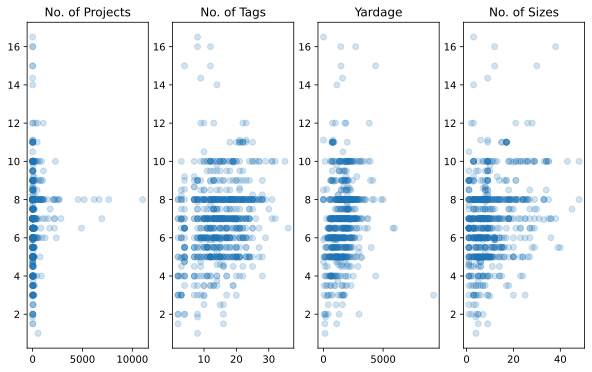

In [20]:
fig = plt.figure(figsize=[10,6])

plt.subplot(1,4,1) # (number of rows, number of columns, number of plot)
plt.scatter(X['num_proj'],y,alpha = 0.2)
plt.title('No. of Projects')
plt.subplot(1,4,2) # (number of rows, number of columns, number of plot)
plt.scatter(X['num_tags'],y,alpha = 0.2)
plt.title('No. of Tags');
plt.subplot(1,4,3) # (number of rows, number of columns, number of plot)
plt.scatter(X['yardage'],y,alpha = 0.2)
plt.title('Yardage');
plt.subplot(1,4,4) # (number of rows, number of columns, number of plot)
plt.scatter(X['size_avail'],y,alpha = 0.2)
plt.title('No. of Sizes');
fig.savefig('continuousVsPrice.png', bbox_inches='tight') 

In [21]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 243 to 808
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   num_proj                               532 non-null    int64  
 1   num_tags                               532 non-null    int64  
 2   gauge                                  532 non-null    float64
 3   yardage                                532 non-null    int64  
 4   size_avail                             532 non-null    int64  
 5   chart                                  532 non-null    int64  
 6   crewneck                               532 non-null    int64  
 7   one-piece                              532 non-null    int64  
 8   seamless                               532 non-null    int64  
 9   top-down                               532 non-null    int64  
 10  unisex                                 532 non-null    int64  
 11  writ

In [23]:
lr = LinearRegression()
lr.fit(X_tr[['Crochet','Knitting']], y_tr)
lr.score(X_tr[['Crochet','Knitting']],y_tr)

0.07287941407535348

In [22]:
#make one feature out of the specific tags
X_tr['newtags'] = X_tr['chart']+X_tr['crewneck']+X_tr['one-piece']+X_tr['seamless']+X_tr['top-down']+X_tr['unisex']+X_tr['written-pattern']


/var/folders/cp/7qmpmnt105b1wpvjj8wd7r140000gp/T/ipykernel_6652/3535906635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr['newtags'] = X_tr['chart']+X_tr['crewneck']+X_tr['one-piece']+X_tr['seamless']+X_tr['top-down']+X_tr['unisex']+X_tr['written-pattern']


In [24]:
lr = LinearRegression()
lr.fit(X_tr[['newtags']], y_tr)
lr.score(X_tr[['newtags']],y_tr)
#doesn't have predictive value on own, but may be a better feature mixed in

0.008945282211350603

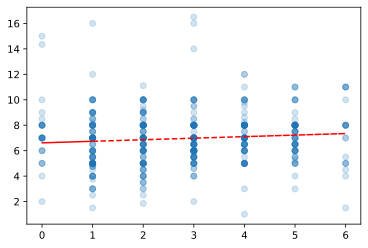

In [25]:
plt.scatter(X_tr['newtags'],y_tr,alpha = 0.2)

z = np.polyfit(X_tr['newtags'], y_tr, 1)
p = np.poly1d(z)
plt.plot(X_tr['newtags'],p(X_tr['newtags']),"r--")

In [26]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV, RidgeCV, ElasticNetCV

from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_tr, y_tr, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
# Build the Model
lin_reg_est.fit(X_tr, y_tr)
#pretty variable r^2, and low value

[0.12530746 0.10403698 0.09009745 0.31346878 0.02770421]
Linear Reg Mean R Squared Score:  0.13212297666550435
variance in scores:  0.009278199969138146


LinearRegression()

In [27]:
#use whole training set
scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
lr_all_train = LinearRegression()
lr_all_train.fit(X_train, y_train)
#less variance if use whole training set like supposed to

[0.18846019 0.04513307 0.21067209 0.21386106 0.14869019]
Linear Reg Mean R Squared Score:  0.16136331881614946
variance in scores:  0.0039183373975603935


LinearRegression()

In [28]:
#one smaller feature set
small_columns1 = ['num_proj','num_tags','gauge','yardage','size_avail','Crochet','Knitting','Loom Knitting','newtags']
smX_tr1 = X_tr[small_columns1]

In [29]:
lin_reg_est_tr1 = LinearRegression()

scores = cross_val_score(lin_reg_est, smX_tr1, y_tr, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
# Build the Model
lin_reg_est_tr1.fit(smX_tr1, y_tr)
#doesn't improve results

[ 0.17811927  0.15640662  0.08158572  0.26737093 -0.07716208]
Linear Reg Mean R Squared Score:  0.12126409297660175
variance in scores:  0.013352406785741233


LinearRegression()

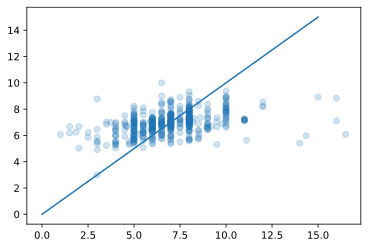

In [30]:
#check the prediction on small_columns1
y_tr_pred = lin_reg_est_tr1.predict(smX_tr1)

plt.scatter(y_tr, y_tr_pred, alpha=0.2)
plt.plot([0, 15], [0, 15]);

In [31]:
#whole training set on first smaller feature set
X_train['newtags'] = X_train['chart']+X_train['crewneck']+X_train['one-piece']+X_train['seamless']+X_train['top-down']+X_train['unisex']+X_train['written-pattern']


smX_train1 = X_train[small_columns1]
lin_reg_est_train1 = LinearRegression()
lin_reg_est_train1.fit(smX_train1, y_train)
scores = cross_val_score(lin_reg_est_train1, smX_train1, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
#variance is smaller with the whole training set

[0.14916388 0.0332369  0.18248427 0.21610189 0.15946969]
Linear Reg Mean R Squared Score:  0.14809132734331423
variance in scores:  0.0038260937973750124


In [32]:
# a still smaller feature set
small_columns2 = ['num_proj','num_tags','gauge','yardage','size_avail','newtags']
smX_tr2 = X_tr[small_columns2]

In [33]:
lin_reg_est_tr2 = LinearRegression()

scores = cross_val_score(lin_reg_est_tr2, smX_tr2, y_tr, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))

# Build the Model
lin_reg_est_tr2.fit(smX_tr2, y_tr)
# still a lot of variability in the r^2 but better than small_columns1
# overall r^2 is worse though

[ 0.12221794  0.08000306  0.10218609  0.18493338 -0.11391107]
Linear Reg Mean R Squared Score:  0.07508587897971972
variance in scores:  0.010153270419730142


LinearRegression()

In [34]:
smX_train2 = X_train[small_columns2]
lin_reg_est_train2 = LinearRegression()

scores = cross_val_score(lin_reg_est_train2, smX_train2, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
#even with entire training set, not a good enough tradeoff between variance & r^2

[ 0.08867075 -0.01590354  0.15803623  0.09751014  0.11046511]
Linear Reg Mean R Squared Score:  0.08775573749099955
variance in scores:  0.0032592588362752965


In [35]:
#even smaller feature set
small_columns3 = ['Crochet','Knitting','Loom Knitting','newtags']
smX_tr3 = X_tr[small_columns3]

lin_reg_est_tr3 = LinearRegression()

scores = cross_val_score(lin_reg_est_tr3, smX_tr3, y_tr, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
# Build the Model
lin_reg_est_tr3.fit(smX_tr3, y_tr)
#negative r^2. not a good choice

[ 0.03359981  0.09574553 -0.04736017  0.12408033  0.03255752]
Linear Reg Mean R Squared Score:  0.04772460455936991
variance in scores:  0.0035213741420199395


LinearRegression()

In [36]:
#another feature set
small_columns4 = ['num_proj','num_tags','gauge','yardage','size_avail','Crochet','Knitting','Loom Knitting','chart','crewneck','one-piece','seamless','top-down','unisex','written-pattern']
smX_tr4 = X_tr[small_columns4]

lin_reg_est_tr4 = LinearRegression()

scores = cross_val_score(lin_reg_est_tr4, smX_tr4, y_tr, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))

# Build the Model
lin_reg_est_tr4.fit(smX_tr4, y_tr)

print(np.var(scores))
#variance in scores is higher than small_columns2 but r^2 is bigger,...
#...but on the third hand result is harder to interpret and present to a client

[ 0.15827644  0.12271957  0.0977877   0.29195466 -0.01670699]
Linear Reg Mean R Squared Score:  0.13080627501548675
0.009927838824915566


In [37]:
#a more meaningful small feature set
small_columns5 = ['gauge','yardage','size_avail','newtags']
smX_train5 = X_train[small_columns5]
lin_reg_est_train5 = LinearRegression()

scores = cross_val_score(lin_reg_est_train5, smX_train5, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
# negative r^2. not a good idea

[ 0.0973264  -0.02233231  0.14674476  0.08240118  0.08353523]
Linear Reg Mean R Squared Score:  0.07753505320498293
variance in scores:  0.003042970541898087


In [38]:
#X_train.info()

In [39]:
#a more meaningful large feature set
#X_train.info()
X_train6 = X_train
X_train6.drop(['num_proj','chart','crewneck','one-piece','seamless','top-down','unisex','written-pattern'],inplace = True, axis = 1)

lin_reg_est_train6 = LinearRegression()
#X_train6.info()
scores = cross_val_score(lin_reg_est_train6, X_train6, y_train, cv=kfold)
lin_reg_est_train6.fit(X_train6, y_train)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))
#looks like best one, taking into consideration the 

[0.15412237 0.05214241 0.1639279  0.2224024  0.17421082]
Linear Reg Mean R Squared Score:  0.1533611777772385
variance in scores:  0.003111774268501551


Text(0.5, 1.0, 'Residuals vs. Predictions')

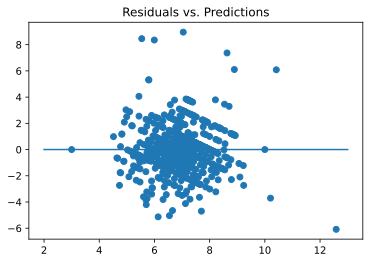

In [40]:
#check the residuals
y_train_pred = lin_reg_est_train6.predict(X_train6)
lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([2,13], [0, 0])
plt.title("Residuals vs. Predictions")

In [41]:
#X_train6.info()

In [42]:
#check with regularization
alpha = np.logspace(-4, 2, 100)
param_grid = dict(alpha=alpha)
grid = GridSearchCV(Lasso(), param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', cv = kfold)
grid_result = grid.fit(X_train6, y_train)


print('Best Score: ', grid_result.best_score_)
print('Best Param: ', grid_result.best_params_)

Best Score:  -1.3176221037642821
Best Param:  {'alpha': 0.01}


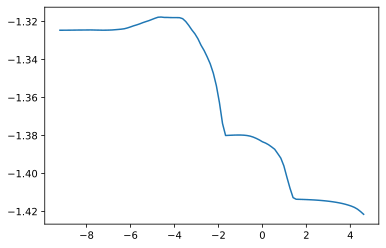

In [43]:
#plotting neg MAE for diff alpha values

df = pd.DataFrame(grid_result.cv_results_)
plt.plot(np.log(alpha), df['mean_test_score'])

In [44]:
#try LASSO on smaller feature set
alpha = np.logspace(-4, 2, 100)
param_grid = dict(alpha=alpha)
grid = GridSearchCV(Lasso(), param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', cv = kfold)
grid_result = grid.fit(smX_train1, y_train)


print('Best Score: ', grid_result.best_score_)
print('Best Param: ', grid_result.best_params_)

Best Score:  -1.3179615924687567
Best Param:  {'alpha': 0.0001}


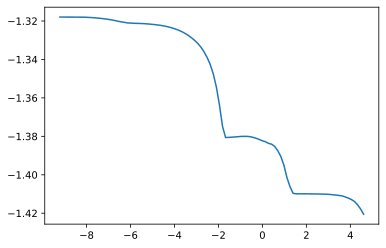

In [45]:
df = pd.DataFrame(grid_result.cv_results_)
plt.plot(np.log(alpha), df['mean_test_score'])

In [46]:
from sklearn.linear_model import lars_path
xtr = X_tr.to_numpy()

print("Computing regularization path using the LARS ...")
alphas, temp, coefs = lars_path(xtr, y_tr,method='lasso')

Computing regularization path using the LARS ...


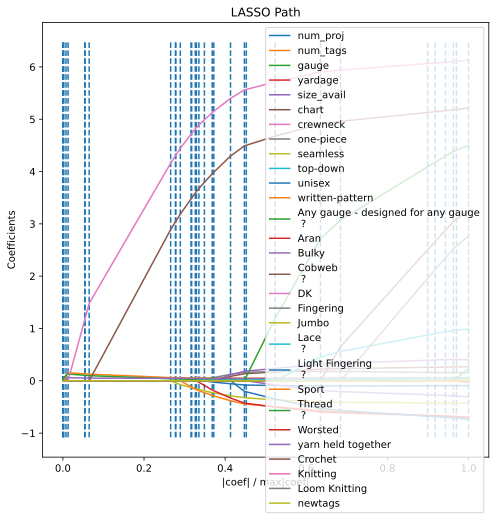

In [47]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(8,8))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr)
plt.show()
#nothing is very good

In [48]:
# try more realistic set with Ridge
alpha = np.logspace(-4, 2, 100) #np.logspace(-4, -.1, 20)
param_grid = dict(alpha=alpha)
grid_ridge = GridSearchCV(Ridge(), param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', cv = kfold)
grid_result_ridge = grid_ridge.fit(X_train6, y_train)


print('Best Score: ', grid_result_ridge.best_score_)
print('Best Param: ', grid_result_ridge.best_params_)

Best Score:  -1.3169873314024234
Best Param:  {'alpha': 12.32846739442066}


In [49]:
# try more realistic set with ElasticNet
alpha = np.logspace(-4, 2, 100) #np.logspace(-4, -.1, 20)
param_grid = dict(alpha=alpha)
grid_en = GridSearchCV(ElasticNet(), param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', cv = kfold)
grid_result_en = grid_en.fit(X_train6, y_train)


print('Best Score: ', grid_result_en.best_score_)
print('Best Param: ', grid_result_en.best_params_)
#alpha isn't very high

Best Score:  -1.3159978423629966
Best Param:  {'alpha': 0.01519911082952933}


In [50]:
#X_val.info()

In [51]:
X_val['newtags'] = X_val['chart']+X_val['crewneck']+X_val['one-piece']+X_val['seamless']+X_val['top-down']+X_val['unisex']+X_val['written-pattern']

X_val6 = X_val

X_val6.drop(['num_proj','chart','crewneck','one-piece','seamless','top-down','unisex','written-pattern'],inplace = True, axis = 1)




#X_val6.info()

/var/folders/cp/7qmpmnt105b1wpvjj8wd7r140000gp/T/ipykernel_6652/1589567614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['newtags'] = X_val['chart']+X_val['crewneck']+X_val['one-piece']+X_val['seamless']+X_val['top-down']+X_val['unisex']+X_val['written-pattern']
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [52]:
X_tr6 = X_tr

X_tr6.drop(['num_proj','chart','crewneck','one-piece','seamless','top-down','unisex','written-pattern'],inplace = True, axis = 1)



In [53]:
from sklearn.metrics import r2_score, mean_squared_error


lr = LinearRegression().fit(X_tr6, y_tr)
y_pred = lr.predict(X_val6)
print("Linear Regression:", r2_score(y_val, y_pred))

lasso = Lasso(alpha = 0.01).fit(X_tr6, y_tr)
y_pred_la = lasso.predict(X_val6)
print("Lasso Regression:", r2_score(y_val, y_pred_la))

ridge = Ridge(alpha = 12.32846739442066).fit(X_tr6, y_tr)
y_pred_ri = ridge.predict(X_val6)
print("Ridge Regression:", r2_score(y_val, y_pred_ri))

en = ElasticNet(alpha = 0.01519911082952933).fit(X_tr6, y_tr)
y_pred_en = en.predict(X_val6)
print("ElasticNet Regression:", r2_score(y_val, y_pred_en))

Linear Regression: 0.16998030147087628
Lasso Regression: 0.1771005935528016
Ridge Regression: 0.17748506850368562
ElasticNet Regression: 0.17778667472506737


In [54]:
ridge_train6 = Ridge(alpha = 12.32846739442066)
#X_train6.info()
scores = cross_val_score(ridge_train6, X_train6, y_train, cv=kfold)
#ridge_train6.fit(X_train6, y_train)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))

[0.16102449 0.04667012 0.1821526  0.22005812 0.17047402]
Linear Reg Mean R Squared Score:  0.15607586966565354
variance in scores:  0.0033950277307290486


In [55]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train6)
lin_reg_est_train1.fit(X_train_poly,y_train)
print(lin_reg_est_train1.score(X_train_poly,y_train))
print(X_train_poly.shape)
# higher but too many features

0.32277573971674367
(666, 253)


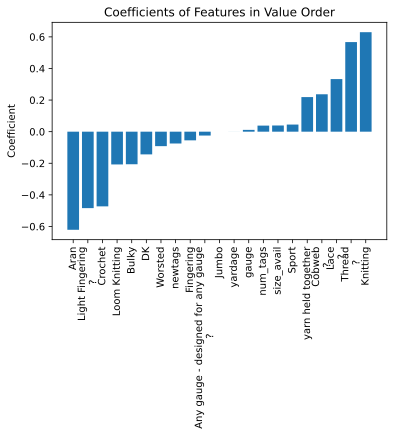

In [56]:
ridge = Ridge(alpha = 12.32846739442066).fit(X_train6, y_train)

#for feature, coef in zip(X_train6.columns, ridge.coef_):
        #print(feature, ':', f'{coef:.2f}') 
qq = list(zip(X_train6.columns,ridge.coef_))
qqq = pd.DataFrame(qq, columns = ['Feature','Coefficient'])
qqq.sort_values('Coefficient', inplace = True)


#g = sns.histplot(qqq,x = 'Feature',y='Coefficient')
#g = sns.histplot(x=qqq['Feature'],y=qqq['Coefficient'])
#g.set_xticklabels(labels = qqq['Feature'],rotation= 90);
fig, ax = plt.subplots()
plt.bar(qqq['Feature'],qqq['Coefficient'])
#addlabels(x,y)
plt.xticks(rotation= 90);

#g.set_xlabel = 'Feature'

ax.set_ylabel('Coefficient')
ax.set_title('Coefficients of Features in Value Order');

fig.savefig('coeff.png', bbox_inches='tight')


In [57]:
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))
print('LR: ',MAE(y_val,y_pred))
print('Lasso: ',MAE(y_val,y_pred_la))
print('Ridge: ',MAE(y_val,y_pred_ri))
print('Elastic: ',MAE(y_val,y_pred_en))

LR:  1.2944820263035184
Lasso:  1.2855775037511752
Ridge:  1.2857686364255432
Elastic:  1.2835318085764125


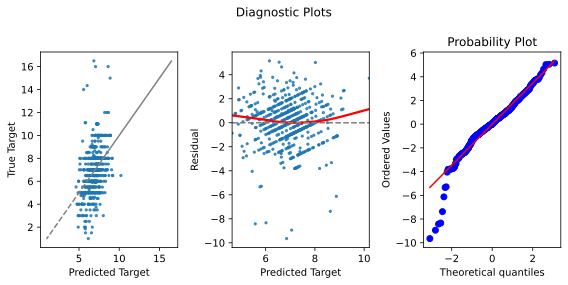

In [58]:

import random
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats

def diagnostic_plots(y_pred, y_true):
    resid = y_pred - y_true
    
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();
    fig.savefig('Diagnostic_Plots.png', bbox_inches='tight')


diagnostic_plots(ridge.predict(X_train), y_train)

 

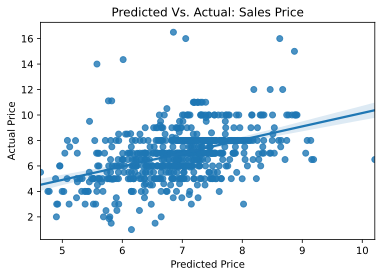

In [59]:
preds = ridge.predict(X_train6) # generate predictions (on training data) using fit model

fig = sns.regplot(x=preds,y=y_train);
fig.set(xlabel='Predicted Price', ylabel='Actual Price',title = 'Predicted Vs. Actual: Sales Price') 
fig.figure.savefig('regplot.png', bbox_inches='tight')



In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rr = pd.DataFrame(scaler.fit_transform(X_train6))
rr.shape



(666, 21)

In [61]:
ridge = Ridge(alpha = 12.32846739442066).fit(rr, y_train)

for feature, coef in zip(X_train6.columns, ridge.coef_):
        print(feature, ':', f'{coef:.2f}')

num_tags : 0.25
gauge : 0.07
yardage : 0.24
size_avail : 0.34
Any gauge - designed for any gauge
 ? : -0.02
Aran : -0.24
Bulky : -0.09
Cobweb
 ? : 0.12
DK : -0.10
Fingering : -0.04
Jumbo : 0.00
Lace
 ? : 0.09
Light Fingering
 ? : -0.14
Sport : -0.00
Thread
 ? : 0.22
Worsted : -0.07
yarn held together : 0.06
Crochet : -0.24
Knitting : 0.19
Loom Knitting : -0.12
newtags : -0.13


In [62]:
ridge_train6 = Ridge(alpha = 12.32846739442066)
#X_train6.info()
scores = cross_val_score(ridge_train6, rr, y_train, cv=kfold)
#ridge_train6.fit(X_train6, y_train)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))
print('variance in scores: ', np.var(scores))

[0.15482473 0.05495953 0.1681707  0.22304802 0.1749526 ]
Linear Reg Mean R Squared Score:  0.1551911132132068
variance in scores:  0.0030420101639831976


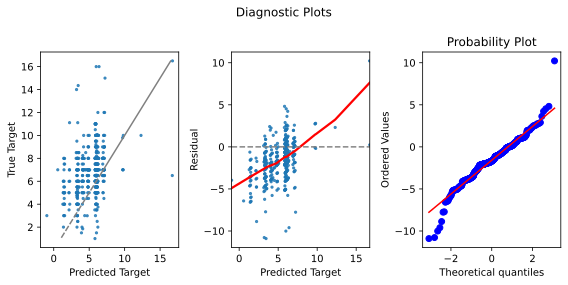

In [63]:
def diagnostic_plots(y_pred, y_true):
    resid = y_pred - y_true
    
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();
    fig.savefig('Diagnostic_Plots_regularized.png', bbox_inches='tight')

ridge_train6.fit(X_tr, y_tr)
diagnostic_plots(ridge_train6.predict(rr), y_train)

In [64]:
#######      TEST. FINAL STEP     ##########
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
just_dummies = pd.get_dummies(X_test['craft'])
X_test = pd.concat([X_test,just_dummies],axis = 1)
X_test.drop(['craft','lang'],inplace = True, axis = 1) #,'Machine Knitting'
X_test['newtags'] = X_test['chart']+X_test['crewneck']+X_test['one-piece']+X_test['seamless']+X_test['top-down']+X_test['unisex']+X_test['written-pattern']
X_test6 = X_test
X_test6.drop(['num_proj','chart','crewneck','one-piece','seamless','top-down','unisex','written-pattern'],inplace = True, axis = 1)
#X_test6.drop(['lang'])
#X_test6.info()




ridge = Ridge(alpha = 12.32846739442066).fit(X_test6, y_test)
y_pred_test_ri = ridge.predict(X_test)
X_train_poly = poly.fit_transform(X_test6)
print("Ridge Regression:", r2_score(y_test, y_pred_test_ri))
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))
print('Ridge MAE: ',MAE(y_test,y_pred_test_ri))

Ridge Regression: 0.22927647117488736
Ridge MAE:  1.2941727828297598
